In [70]:
import numpy as np
import skimage.io
import base64
import rpyc
import time
import os
import matplotlib.pyplot as plt
import socket
import glob
import random

In [105]:
# Pick test image randomly
test_image_list = glob.glob('/home/srirampendyala/Projects/MM_connect/micronucleus/test_08_22_19/*/image.npy')
#test_image = random.choice(test_image_list)
test_image = '/home/srirampendyala/Projects/MM_connect/micronucleus/test_08_22_19/214/image.npy'
print(test_image)

/home/srirampendyala/Projects/MM_connect/micronucleus/test_08_22_19/214/image.npy


In [106]:
# Import test image
np_pixels = np.load(test_image)
np_pixels = np_pixels[:,1:,:]
height, width, depth = np_pixels.shape
print((height,width,depth))

(768, 869, 2)


In [107]:
def normalize_image(img):
    
    if len(img.shape) == 2:
        
        percentile = 99.9
        high = np.percentile(img, percentile)
        low = np.percentile(img, 100-percentile)

        img = np.minimum(high, img)
        img = np.maximum(low, img)

        img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
        img = skimage.img_as_ubyte(img)

        # make a RGB-channel color image
        img_norm = np.stack([img, img, img], axis=-1)
        
    else:
        img_norm = np.zeros(img.shape, dtype='uint8')
        for ix in range(img.shape[2]):
            
            img_channel =  img[:,:,ix]
            percentile = 99.9
            high = np.percentile(img_channel, percentile)
            low = np.percentile(img_channel, 100-percentile)

            img_channel = np.minimum(high, img_channel)
            img_channel = np.maximum(low, img_channel)

            img_channel = (img_channel - low) / (high - low) # gives float64, thus cast to 8 bit later
            img_norm[:,:,ix] = skimage.img_as_ubyte(img_channel)
            
    return img_norm

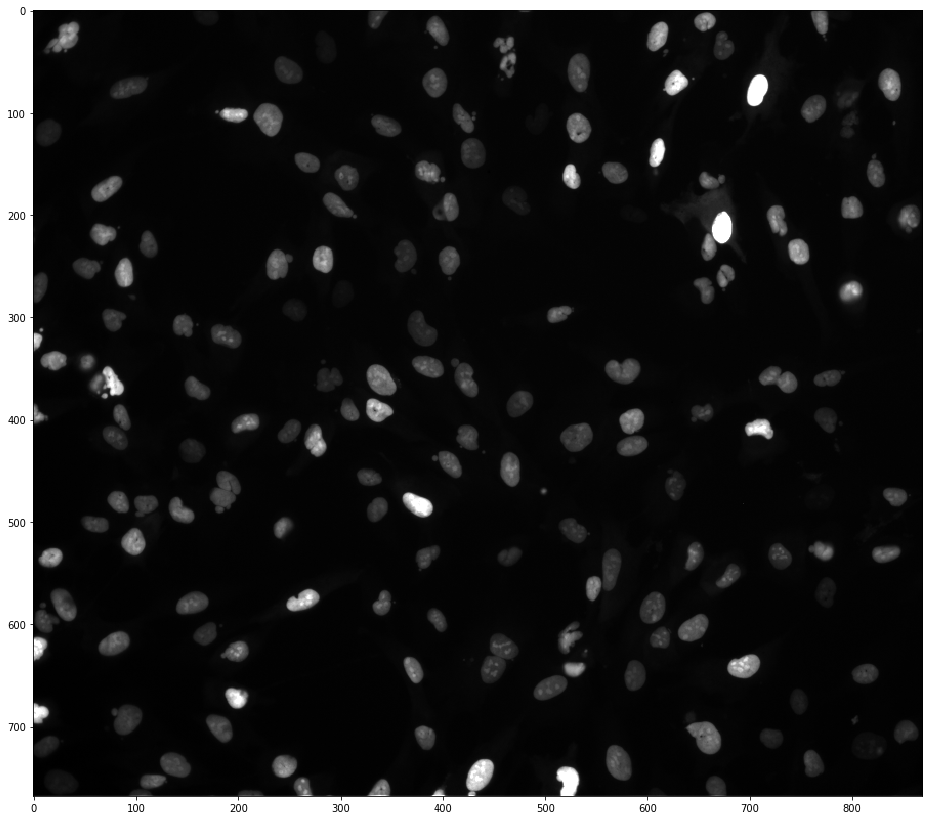

In [108]:
#print dendra image
plt.figure(num=None, figsize=(13.5,11.5))
skimage.io.imshow(normalize_image(np_pixels[:,:,1]))
plt.show()

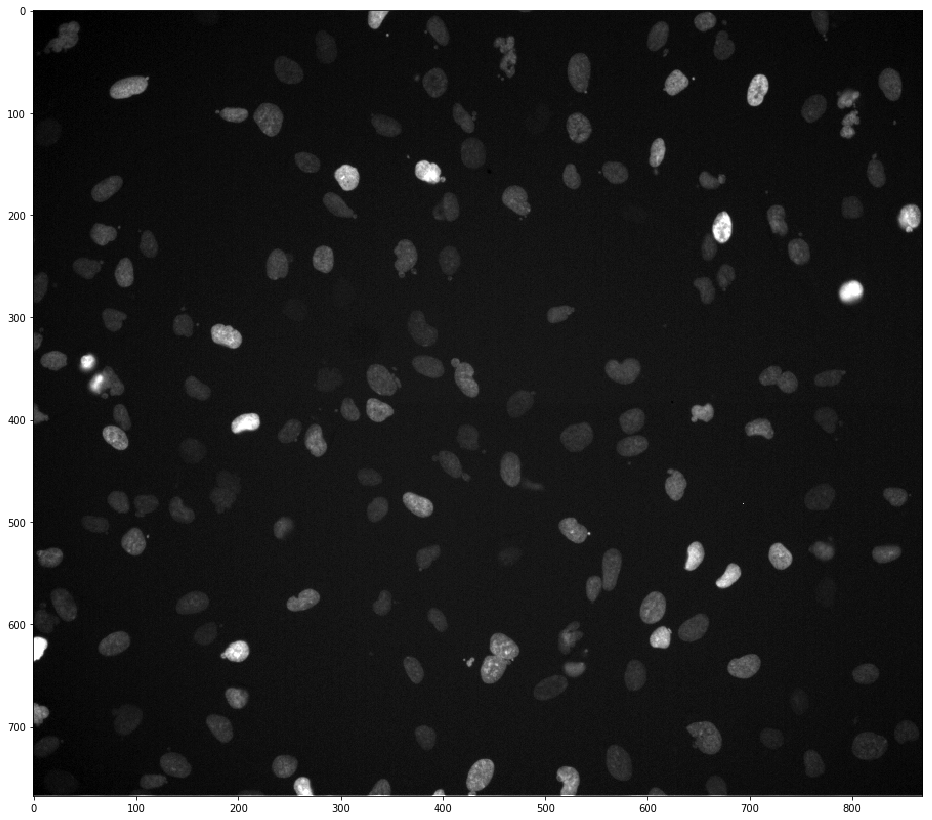

In [109]:
#print miRFP image
plt.figure(num=None, figsize=(13.5,11.5))
skimage.io.imshow(normalize_image(np_pixels[:,:,0]))
plt.show()

In [110]:
def get_outputmask(image_name, output_mask):
    #....
    print("call back in client", image_name)

In [111]:
# Send to GPU server
start = time.time()
while True:
    try:
        conn = rpyc.connect("128.208.8.66", 18871)
        break
    except socket.timeout:
        print('Caught a timeout! Reconnecting...')
        time.sleep(2)
bgsrv = rpyc.BgServingThread(conn)
mon = conn.root.ImageAnalysis(get_outputmask)
b64_output_mask = mon.run_pipeline_on_image('test_img', base64.b64encode(np.ascontiguousarray(np_pixels)))
np_output_mask = np.frombuffer(base64.decodebytes(b64_output_mask), np.uint8).reshape((height,width))
bgsrv.stop()
conn.close()
end = time.time()
print('Wall time: ' + str((end-start)*1000) + 'ms')

Wall time: 4107.999086380005ms


/home/srirampendyala/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/srirampendyala/anaconda3/envs/deep-learning/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


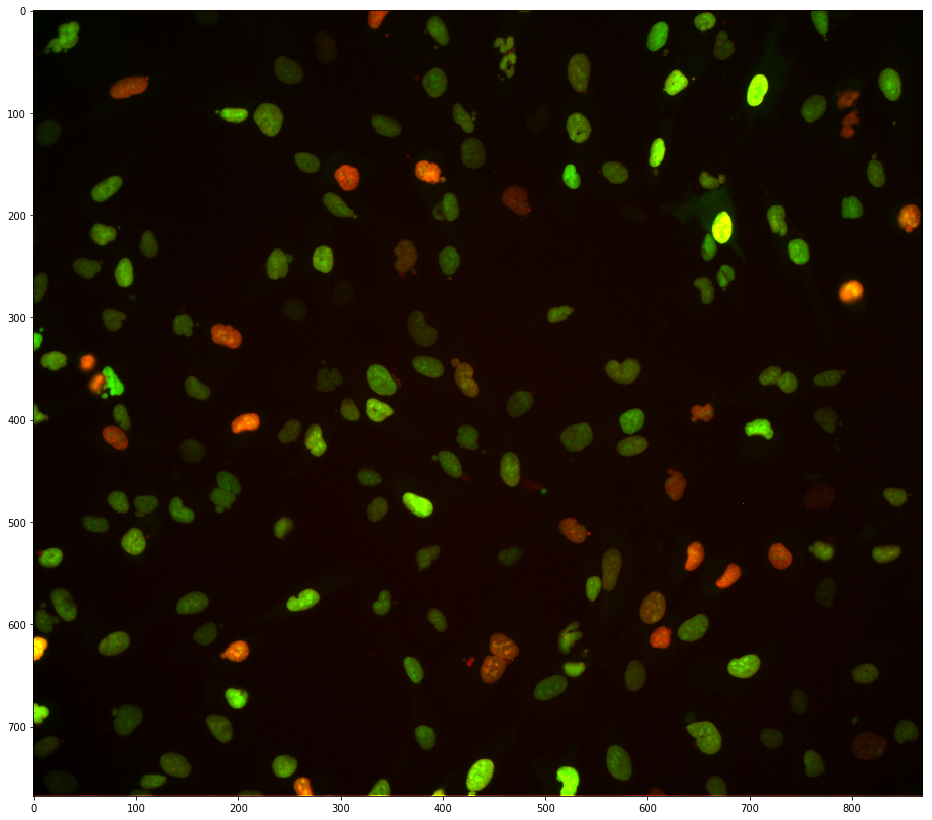

/home/srirampendyala/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


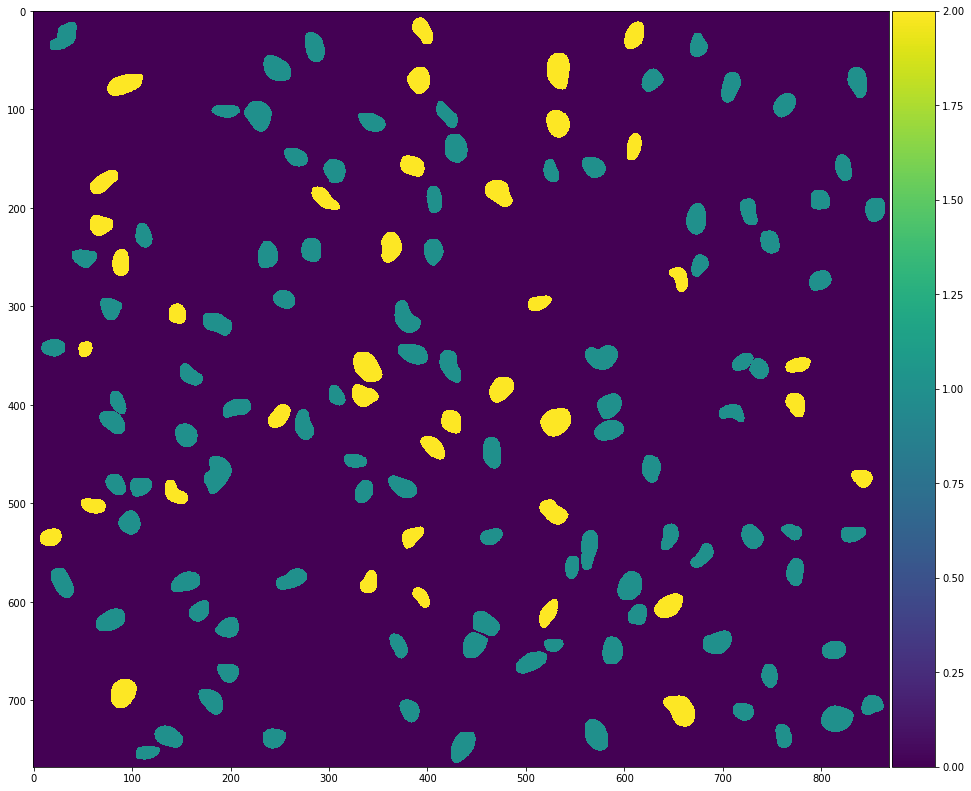

In [112]:
#Visualize both image and mask
plt.figure(num=None, figsize=(13.5,11.5))
np_pixels_show = np.zeros((height,width,3))
np_pixels_show[:,:,0:2] = np_pixels
np_pixels_show = normalize_image(np_pixels_show)
skimage.io.imshow(np_pixels_show)
plt.show()

plt.figure(num=None, figsize=(13.5,11.5))
skimage.io.imshow(np_output_mask)
plt.show()